# 1. Chargement des librairies et données

## 1.1. Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## 1.2. Import des données

In [2]:
dataset = pd.read_csv("./dataset/insurance.csv")
df = pd.DataFrame(dataset)

display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.3. Vérification des données

In [3]:
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublon supprimé")

print("\nDonnées manquantes :")
display(df.isna().sum())
print("\n→ Pas de données manquantes")

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublon supprimé

Données manquantes :


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


→ Pas de données manquantes


In [4]:
df["obese"] = (df["bmi"].map(lambda x: "no" if x < 30 else "yes"))

display(df.head())

,age,sex,bmi,children,smoker,region,charges,obese
0,19,female,27.900,0,yes,southwest,16884.92400,no
1,18,male,33.770,1,no,southeast,1725.55230,yes
2,28,male,33.000,3,no,southeast,4449.46200,yes
3,33,male,22.705,0,no,northwest,21984.47061,no
4,32,male,28.880,0,no,northwest,3866.85520,no


# 2. Modélisation automatisée

## 2.1. Split test-train

In [5]:
# Division en données d'entraînement (80 %) et données de test (20 %)

X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

## 2.2. Création et sauvegarde de la pipeline

In [6]:
# Récupération des variables numériques et catégorielles
cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()


# Définition de la mise à l'échelle des variables
scaler = ColumnTransformer(transformers = [("ohe_sex_smoker_children", OneHotEncoder(drop="first"), cat_cols),
                                                ("standard_age_bmi_children", StandardScaler(), num_cols)
                                                ])


# Création de la pipeline
pipeline = Pipeline([
    ("scaler", scaler),
    ("regressor", LinearRegression())
])


# Sauvegarde du modèle
filename = f"./models/model_1.pkl"
joblib.dump(pipeline, open(filename, "wb"))

## 2.3. Cross validation

In [ ]:
# Evaluation du modèle (MAE) avec validation croisée
scores = cross_val_score(
    estimator = pipeline,
    X = X_train,
    y = y_train,
    cv = 5,
    scoring = "neg_mean_absolute_error"
)


print(np.abs(scores.round(4)))


[4427.3452 4093.6572 4074.53   4429.7346 4191.3855]


## 2.4. Comparaison de modèles avec GridSearchCV

## 2.5. Prédictions sur les données de test


Mesures de performance (test) :


,R2,MAE,MSE
0,0.8055,4287.4678,5978.258


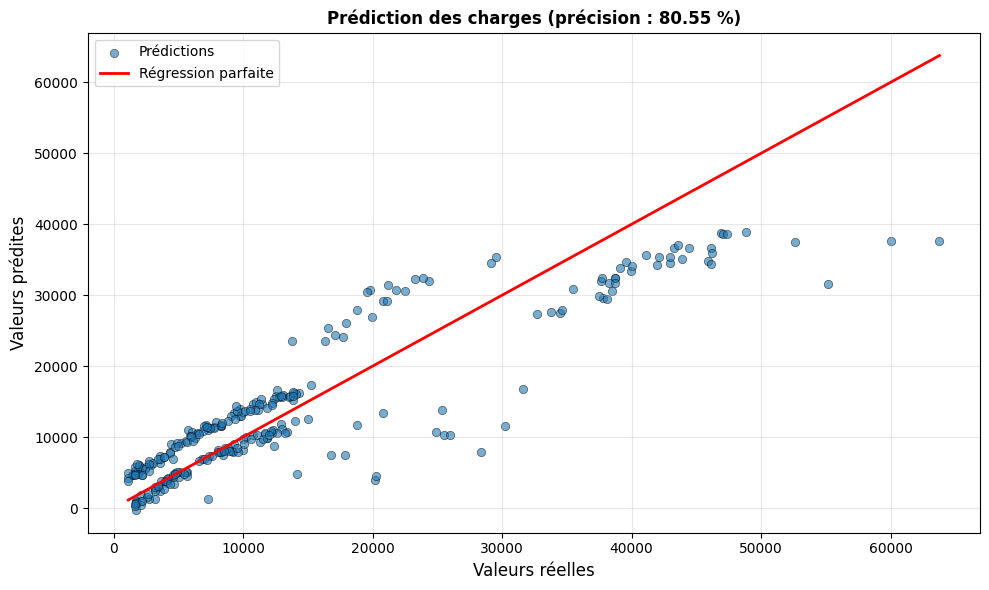

In [8]:
# Entraînement du modèle et prédictions sur les données de test
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


# Evaluation du modèle sur les données de test (scores R2, MAE, RMSE)
titles = ["R2", "MAE", "MSE"]

r2 = r2_score(y_test, y_pred)

scores = [
    r2,
    np.mean(np.abs(y_test - y_pred)),
    (mean_squared_error(y_test, y_pred)) ** 0.5
]

df_scores = pd.DataFrame([scores], columns=titles)

print(f"\nMesures de performance (test) :")

display(df_scores.round(4))



# Représentation graphique des prédictions
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", linewidth=0.5, label="Prédictions")

plt.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            "r-", lw=2, label="Régression parfaite")

plt.xlabel("Valeurs réelles", fontsize=12)
plt.ylabel("Valeurs prédites", fontsize=12)
plt.title(f"Prédiction des charges (précision : {r2 * 100:.2f} %)", fontsize=12, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# 3. Chargement d'un modèle existant

In [9]:
filename = f"./models/model_1.pkl"
loaded_model = joblib.load(open(filename, "rb"))